In [1]:
import sys

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
from numpy.polynomial.polynomial import polyfit, polyval
from scipy.stats import pointbiserialr
import networkx as nx
from sklearn.cross_decomposition import PLSCanonical

from scipy.stats import pearsonr

import mne
mne_object=mne.io.read_raw_fif('./util/chan_locs/TMSi32chan_loc_small.fif')


Opening raw data file ./util/chan_locs/TMSi32chan_loc_small.fif...
Isotrak not found
    Range : 0 ... 2000 =      0.000 ...     1.000 secs
Ready.


/tmp/ipykernel_1137141/3388744621.py:24: RuntimeWarning: This filename (./util/chan_locs/TMSi32chan_loc_small.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_object=mne.io.read_raw_fif('./util/chan_locs/TMSi32chan_loc_small.fif')


In [2]:
# (Color Scheme) 
red         = [1, 0, 0]
pink        = [1, 0.65, 0.75]
black       = [0, 0, 0]
white       = [1, 1, 1]
blue        = [0, 0, 1]
mediumblue  = [0, 0.4, 0.7]
green       = [0, 1, 0]
darkgreen   = [0, 0.5, 0]
grey        = [0.5, 0.5, 0.5]
yellow      = [1, 1, 0]
deepyellow  = [1, 0.8, 0.2]
gold        = [212/255, 175/255, 55/255]
brown       = [150/255, 75/255, 0]
magenta     = [1, 0, 1] 
cyan        = [0, 1, 1]  
purple      = [0.6, 0.1, 0.9]

# % https://www.mathworks.com/help/matlab/creating_plots/specify-plot-colors.html
matlab_blue     = [0, 0.4470, 0.7410]
matlab_orange   = [0.8500, 0.3250, 0.0980]
matlab_gold     = [0.9290, 0.6940, 0.1250]
matlab_purple   = [0.4940, 0.1840, 0.5560]
matlab_green    = [0.4660, 0.6740, 0.1880]
matlab_cyan     = [0.3010, 0.7450, 0.9330]
matlab_red      = [0.6350, 0.0780, 0.1840]

# combine colors
condicolors = [darkgreen, red, blue, magenta, purple, purple]
dire3colors = [darkgreen, brown, magenta]
syn2colors = [darkgreen, pink]
HNLcolors = [darkgreen, deepyellow, pink]
freq7colors = [black, red, deepyellow, darkgreen, matlab_blue, blue, matlab_purple]

color_4st=[matlab_green,red,blue,black]

In [3]:
# load chan locs for topoplots
dict_loc=loadmat('./util/chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('./util/chan_locs/pos.mat')
pos=pos_mat['pos']


# construct full edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

In [4]:
# variable names for plotting
states4names=['Independent','Leading','Following','Mutual']
syn2names=['Synchronization','Syncopation']
states3names=['Independent','Unidirectional','Bidirectional']
band_labels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']

In [5]:
indices=loadmat('Indicies.mat')
syn2_condi4_ind     = indices['syn2_condi4_ind']
indices.keys()

dict_keys(['L_lead_ind', 'L_lead_synch_ind', 'L_lead_synco_ind', 'Mutual_ind', 'Mutual_synch_ind', 'Mutual_synco_ind', 'R_lead_ind', 'R_lead_synch_ind', 'R_lead_synco_ind', 'Uncoupled_ind', 'Uncoupled_synch_ind', 'Uncoupled_synco_ind', 'condi4_ind', 'syn2_condi4_ind', 'syn_ind', 'synch_condi4_ind', 'synch_ind', 'synco_condi4_ind', 'synco_ind'])

In [6]:
hurstdict = loadmat('H.mat')
hurstdict.keys()
H= hurstdict['H']
H.shape

(144, 2)

In [7]:
#organize hurst exponents 
H_follow_synco = np.zeros(36)
H_lead_synco = np.zeros(36)
H_ind_synco = np.zeros(36)
H_mutual_synco = np.zeros(36)
H_follow_synch = np.zeros(36)
H_lead_synch = np.zeros(36)
H_ind_synch = np.zeros(36)
H_mutual_synch = np.zeros(36)

H_follow_synco[0:18] = H[indices['R_lead_synco_ind'],0]
H_follow_synco[18:36] = H[indices['L_lead_synco_ind'],1]
H_lead_synco[0:18] = H[indices['L_lead_synco_ind'],0]
H_lead_synco[18:36] =H[indices['R_lead_synco_ind'],1]
H_mutual_synco[0:18] = H[indices['Mutual_synco_ind'],0] 
H_mutual_synco[18:36] = H[indices['Mutual_synco_ind'],1]
H_ind_synco[0:18] = H[indices['Uncoupled_synco_ind'],0]
H_ind_synco[18:36] = H[indices['Uncoupled_synco_ind'],1]

H_follow_synch[0:18] = H[indices['R_lead_synch_ind'],0]
H_follow_synch[18:36] = H[indices['L_lead_synch_ind'],1]
H_lead_synch[0:18] = H[indices['L_lead_synch_ind'],0]
H_lead_synch[18:36] =H[indices['R_lead_synch_ind'],1]
H_mutual_synch[0:18] = H[indices['Mutual_synch_ind'],0] 
H_mutual_synch[18:36] = H[indices['Mutual_synch_ind'],1]
H_ind_synch[0:18] = H[indices['Uncoupled_synch_ind'],0]
H_ind_synch[18:36] = H[indices['Uncoupled_synch_ind'],1]

In [8]:
# organized into np
H_synch=[H_ind_synch, H_lead_synch, H_follow_synch, H_mutual_synch]
H_synco=[H_ind_synco, H_lead_synco, H_follow_synco, H_mutual_synco]
H_syn=[H_synch, H_synco]

In [9]:
corrdict=loadmat('Corr_eeg144.mat')

eeg_empirical_correlation144x2  = corrdict['eeg_empirical_correlation144x2']     
eeg_partial_correlation144x2    = corrdict['eeg_partial_correlation144x2']       
intervals144                    = corrdict['intervals144']                       
samples144                      = corrdict['samples144']                         
session144                      = corrdict['session144']                         

In [10]:
#organize the adjacency matrices from partial correlation
eeg_partial_correlation144x2 = eeg_partial_correlation144x2.astype(bool)
        
A_follow_synco = np.zeros((36,7,32,32))
A_lead_synco = np.zeros((36,7,32,32))
A_ind_synco = np.zeros((36,7,32,32))
A_mutual_synco = np.zeros((36,7,32,32))
A_follow_synch = np.zeros((36,7,32,32))
A_lead_synch = np.zeros((36,7,32,32))
A_ind_synch = np.zeros((36,7,32,32))
A_mutual_synch = np.zeros((36,7,32,32))

A_follow_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:]
A_follow_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:]
A_lead_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:]
A_lead_synco[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:]
A_mutual_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] 
A_mutual_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
A_ind_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
A_ind_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

A_follow_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
A_follow_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
A_lead_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
A_lead_synch[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
A_mutual_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
A_mutual_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
A_ind_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
A_ind_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]

In [11]:
# organized into np array (edges)
A_synch=[A_ind_synch, A_lead_synch, A_follow_synch, A_mutual_synch]
A_synco=[A_ind_synco, A_lead_synco, A_follow_synco, A_mutual_synco]
A_syn=[A_synch, A_synco]

In [12]:
# real correlation (edges)
r_AH=np.zeros((2,4,7,32,32))
p_AH=np.zeros((2,4,7,32,32))
for syn in range(2):
    for st in range(4):
        for freq in range(7):
            for k in range(32):
                for l in range(32):
                    r_AH[syn,st,freq,k,l], p_AH[syn,st,freq,k,l] = pointbiserialr(
                        A_syn[syn][st][:,freq,k,l],H_syn[syn][st])
# 46 s

/home/zhibinz2/anaconda3/envs/mne/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [13]:
# # This step takes over an hour, output was saved already, can skip to save time
# # simulate 36 random graph to get correlation and repeat 100 times (edges)
# r100_4ArH=np.zeros((100,2,4,7,32,32)) # Distribution
# for r in range(100):
#     # construct 36 random network with matched number of edges
#     Ar_syn=np.zeros((2,4,36,7,32,32)) # 36 random graph
#     for syn in range(2):
#         for st in range(4): # only for mutual
#             for tr in range(36):
#                 for freq in range(7):
#                     G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
#                     nEdges = len(G.edges())
#                     R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
#                     Ar = nx.adjacency_matrix(R).toarray() # random graph matrix
#                     Ar_syn[syn,st,tr,freq,:,:] = Ar
#                     del(G,R,Ar)
#     # compute correlation
#     r_ArH=np.zeros((2,4,7,32,32))
#     p_ArH=np.zeros((2,4,7,32,32))
#     for syn in range(2):
#         for st in range(4):
#             for freq in range(7):
#                 for k in range(32):
#                     for l in range(32):
#                         r_ArH[syn,st,freq,k,l], p_ArH[syn,st,freq,k,l]= pointbiserialr(
#                             Ar_syn[syn][st][:,freq,k,l],H_syn[syn][st])
#                 r100_4ArH[r,syn,st,freq,:,:]=r_ArH[syn,st,freq,:,:]

# # this step takes about 18 min x 4 st = 72 min, to save time, the output was saved already
# outdict = dict()
# outdict['r100_4ArH']       = r100_4ArH
# savemat('r100_4ArH',outdict,store_python_metadata = True) 


In [14]:
outdict=loadmat('r100_4ArH.mat')
r100_4ArH  = outdict['r100_4ArH']

In [15]:
# z-score estimate (edges)
zscore_AH=np.zeros((2,4,7,32,32)) 
for syn in range(2):
    for st in range(4): # only for mutual
        for freq in range(7):
            for i in range(32):
                for j in range(32):
                    r_distri_random = r100_4ArH[:,syn,st,freq,i,j]
                    r_AH_real=r_AH[syn,st,freq,i,j]
                    r_distri_random = [r_AH_real]+r_distri_random.tolist()
                    zscores=stats.zscore(r_distri_random)
                    zscore_AH[syn,st,freq,i,j]=zscores[0]
                    del(r_distri_random)

In [16]:
# compute degree centrality (nodes)
cc3_syn=np.zeros((1,2,4,36,7,32))
for syn in range(2):
    for st in range(4):
        for freq in range(7):
            for tr in range(36):
                G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
                x0=nx.clustering(G)
                x1=nx.degree_centrality(G)
                x2=nx.betweenness_centrality(G)
                del(G)
                for chan in range(32):
                    cc3_syn[0,syn,st,tr,freq,chan]=x1[chan]
# 10 s

In [17]:
# real correlation (nodes)
r_ccH=np.zeros((1,2,4,7,32))
p_ccH=np.zeros((1,2,4,7,32))
for ccc in range(1):
    for syn in range(2):
        for st in range(4):
            for freq in range(7):
                for chan in range(32):
                    r_ccH[ccc,syn,st,freq,chan],p_ccH[ccc,syn,st,freq,chan]= pearsonr(
                        cc3_syn[ccc,syn,st,:,freq,chan],H_syn[syn][st])

In [18]:
# # # This step takes hours, output was saved already, can skip to save time
# # simulate 36 random network to get a correlation then repeat 100 times (nodes)
# r100_4crH=np.zeros((100,1,2,4,7,32)) # Distribution
# for r in range(100):
#     # construct 36 random network with matched number of edges
#     cr3_syn=np.zeros((2,4,7,36,3,32)) # 36 random graph
#     for syn in range(2):
#         for st in range(4): # all condition
#             for tr in range(36):
#                 for freq in range(7):
#                     G=nx.from_numpy_array(A_syn[syn][st][tr,freq,:,:])
#                     nEdges = len(G.edges())
#                     R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
#                     xr=np.zeros((1,32))
#                     for chan in range(32):
#                         xr[0,chan]=nx.degree_centrality(R)[chan]
#                     cr3_syn[syn,st,freq,tr,:,:]=xr
#     # compute correlation
#     r_crH=np.zeros((1,2,4,7,32))
#     p_crH=np.zeros((1,2,4,7,32))
#     for c in range(1):
#         for syn in range(2):
#             for st in range(4):
#                 for freq in range(7):
#                     for chan in range(32):
#                         r_crH[c,syn,st,freq,chan],p_crH[c,syn,st,freq,chan]= pearsonr(
#                             cr3_syn[syn,st,freq,:,c,chan],H_syn[syn][st])
#                     r100_4crH[r,c,syn,st,freq,:]=r_crH[c,syn,st,freq,:]
# # 2h x 4 st = 8 h
# outdict = dict()
# outdict['r100_4crH']       = r100_4crH
# savemat('r100_4crH',outdict,store_python_metadata = True) 

In [23]:
outdict=loadmat('r100_4crH.mat')
r100_4crH  = outdict['r100_4crH']

In [24]:
# z-score estimate (nodes)
zscore_crH=np.zeros((1,2,4,7,32))
for ccc in range(1):
    for syn in range(2):
        for st in range(4): # only for mutual
            for freq in range(7):
                for chan in range(32):
                    crH_distri_random=r100_4crH[:,ccc,syn,st,freq,chan]
                    r_crH_real=r_ccH[ccc,syn,st,freq,chan]
                    r_distri_random=[r_crH_real]+crH_distri_random.tolist()
                    zscores=stats.zscore(r_distri_random)
                    zscore_crH[ccc,syn,st,freq,chan]=zscores[0]
# 0.5 s

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


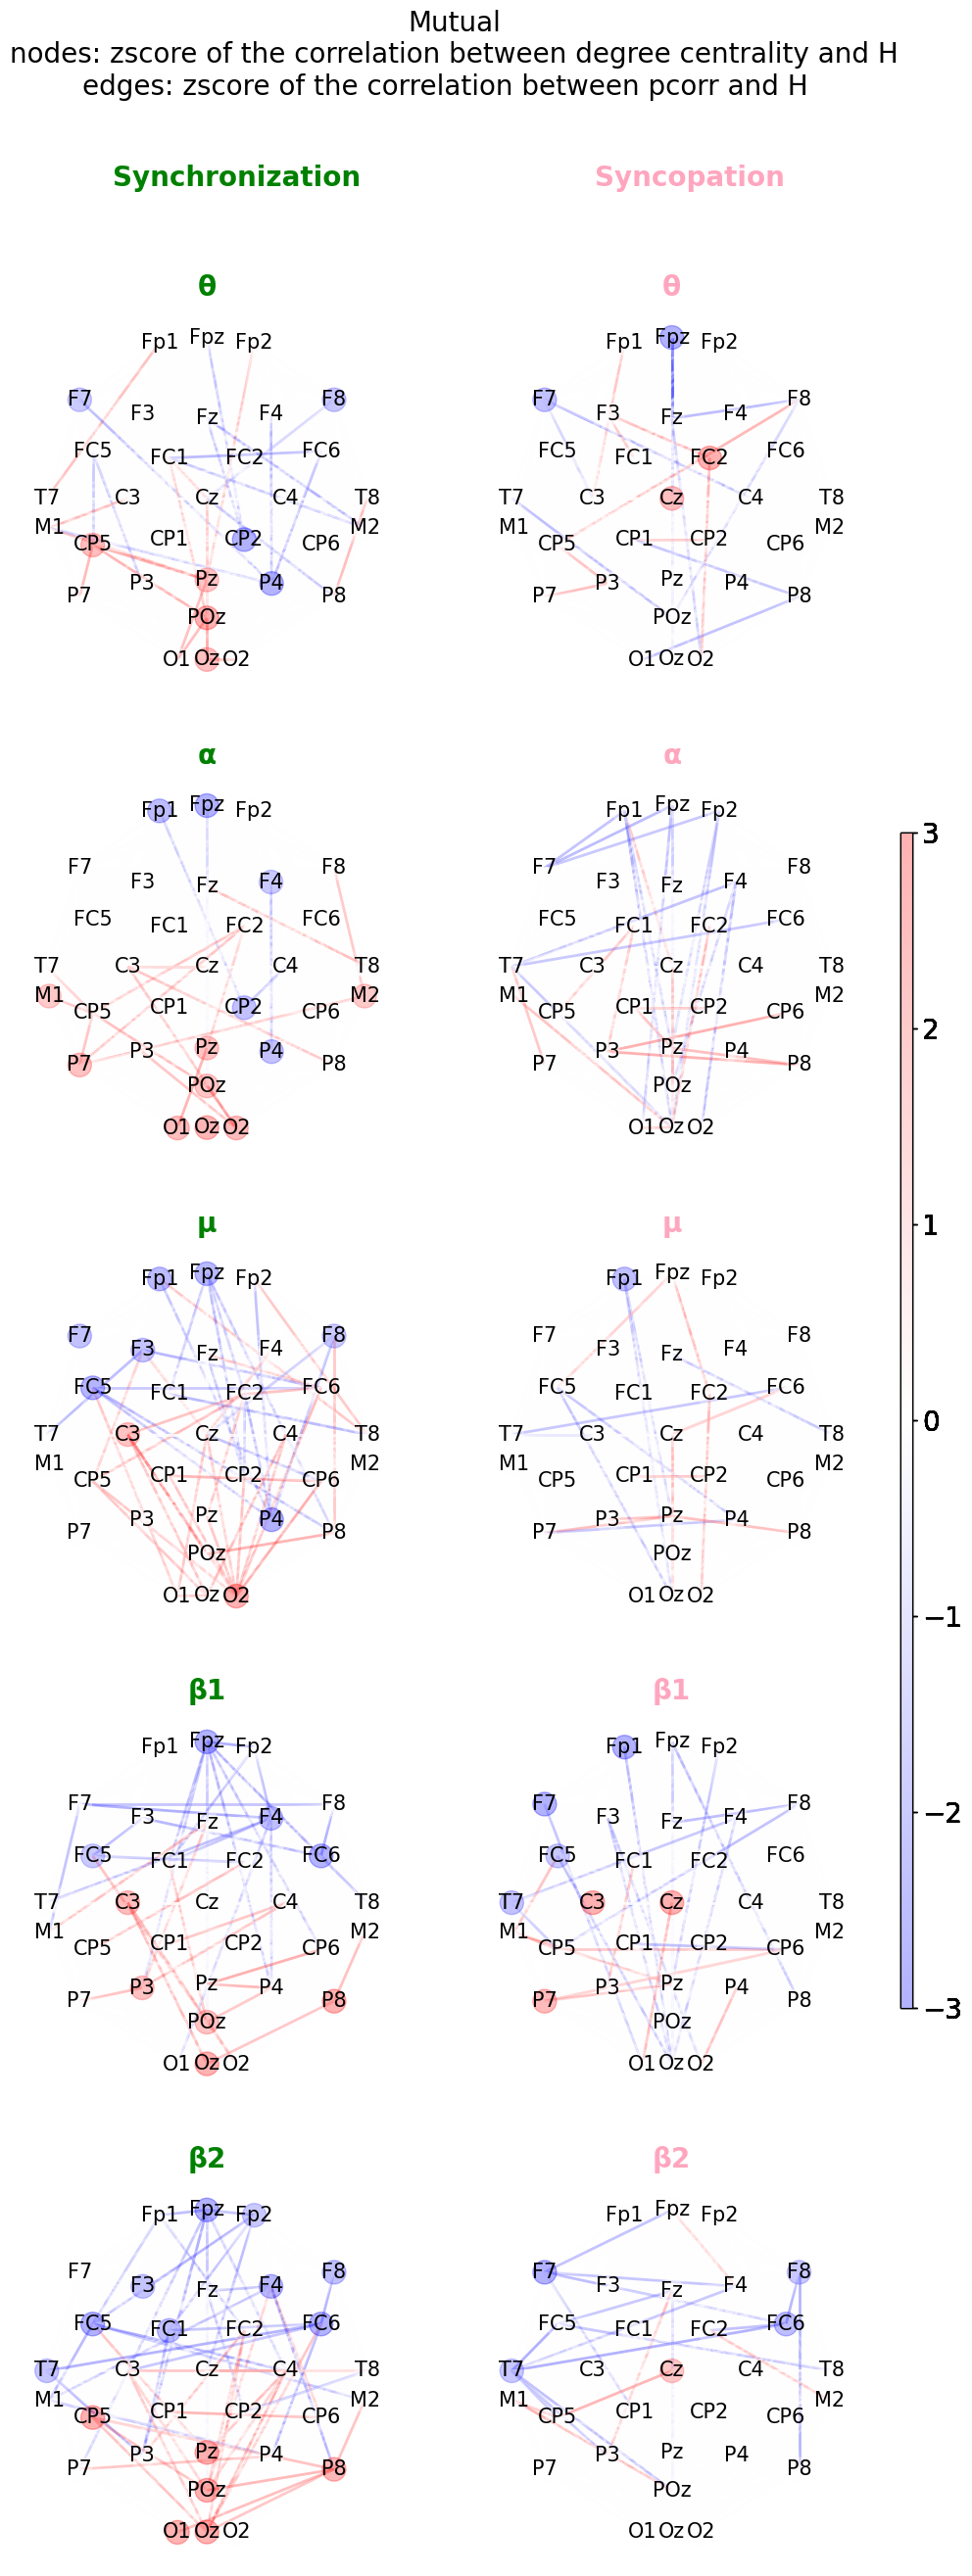

In [25]:
# plot the zscore in networkx
import copy
ctr3names=['degree centrality']
greek_labels=['θ','α','μ','β1','β2',]
vmin_node_c=-3
vmax_node_c=3
vmin_edge_c=-3
vmax_edge_c=3
zscore_lim=2
for ccc in range(1):
        for st in range(3,4):
            fig, ax = plt.subplots(5,2,figsize=(6*2, 6*5))
            for syn in range(2):
                    for freq in range(1,6):
                            plt.sca(ax[freq-1, syn])
                            data = zscore_AH[syn,st,freq,:,:]
                            X=nx.from_numpy_array(data)
                            X.remove_edges_from(nx.selfloop_edges(X))
                            edges,edge_colors = zip(*nx.get_edge_attributes(X,'weight').items())
                            copy_edge_colors=np.asarray(copy.deepcopy(edge_colors))
                            for e in range(len(copy_edge_colors)):
                                    if copy_edge_colors[e]<zscore_lim and copy_edge_colors[e]>-1*zscore_lim:
                                            copy_edge_colors[e]=0

                            ctr32=copy.deepcopy(zscore_crH[ccc,syn,st,freq,:])
                            for chan in range(32):
                                    if ctr32[chan]<zscore_lim and ctr32[chan]>-1*zscore_lim:
                                            ctr32[chan]=0

                                            
                            nx.draw_networkx_labels(X, pos, labels=labeldict, font_size=15,font_weight=4)
                            nodes=nx.draw_networkx_nodes(X, pos, node_size=300, 
                                            node_color=ctr32, vmin=vmin_node_c, vmax=vmax_node_c, 
                                            cmap='bwr', alpha=0.3)
                            edges=nx.draw_networkx_edges(X, pos, width=2, 
                                    edge_color=copy_edge_colors,edge_vmin=vmin_edge_c,edge_vmax=vmax_edge_c,
                                    edge_cmap=plt.cm.bwr,alpha=0.3)
                            title = greek_labels[freq-1]
                            ax[freq-1, syn].set_title(title, fontsize = 20, color=syn2colors[syn], fontweight="bold") 
                            ax[freq-1, syn].axis('off')


                            fig.subplots_adjust(right=0.85)
                            cbar_ax2 = fig.add_axes([0.88, 0.3, 0.01, 0.4])
                            cbar_edges=fig.colorbar(nodes,cbar_ax2)
                            cbar_edges.ax.tick_params(labelsize=20)


            plt.suptitle(states4names[st]+'\nnodes: zscore of the correlation between ' + ctr3names[ccc] + ' and H\n'
                    + 'edges: zscore of the correlation between pcorr and H  ',
            fontsize=20)

            plt.figtext(0.21,0.92,syn2names[0], fontsize=20, color=syn2colors[0], fontname="Times New Roman", fontweight="bold")
            plt.figtext(0.62,0.92,syn2names[1], fontsize=20, color=syn2colors[1], fontname="Times New Roman", fontweight="bold")



# 7s
